# Final Project: Intro to Machine Learning 
# Decoding the Hall of Fame Ballot
### by Julian Moscotte

## Problem Description:

Baseball is one of the sports with the widest array of data, largely do to the massive amount of information gained on any 1 given play. There's pitching, fielding, batting, and even baserunning data, so there's ample points to work with for just 1 player. A particular interest of mine is the selection process for the Hall of Fame in the MLB. Ideally, this is reserved for the best of the best and I want to tackle a classifier that predicts Hall of Fame players, and train it to identify players who have not been inducted but maybe deserve to be and to find players who are not yet eligible but have strong chances to make it when they are. For this final project we will only use simple batting statistics, meaning no advanced metrics like WAR or JAWS which do a lot of the work for us. We'll see if just your simple pen and paper stats can do the work to tell us who deserves a trip to Cooperstown.  

The first step of this project must be to gather the data and get it to a place to work with. Below is the result of some manual scraping of the internet for a total dataset of all baseball players with a minimum of 100 games. This largley reduces the amount of players who never quite got a footing in the MLB as well as rookies who played less than 100 games between 2022 and 2023.

In [290]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc,roc_auc_score
from sklearn.ensemble import RandomForestClassifier


## EDA

Loading in total data

In [291]:
# Set the path to the folder containing the Excel files
folder_path = ('data/batting_data')

# Get a list of all Excel files in the folder
excel_files = [f for f in os.listdir(folder_path) if f.endswith('.xls') or f.endswith('.xlsx')]
dfs = []

# Iterate through each Excel file and read it into a DataFrame
for file in excel_files:
    file_path = os.path.join(folder_path, file)
    df = pd.read_html(file_path)
    dfs.append(df[0])

batting_stats_total = pd.concat(dfs, axis=0, ignore_index=True)

Loading in HOF specific data set, there was no indicator so we'll create one ourselves.

In [292]:
folder_path = ('data/hof_batting_data')

# Get a list of all Excel files in the folder
excel_files = [f for f in os.listdir(folder_path) if f.endswith('.xls') or f.endswith('.xlsx')]
dfs = []

# Iterate through each Excel file and read it into a DataFrame
for file in excel_files:
    file_path = os.path.join(folder_path, file)
    df = pd.read_html(file_path)
    dfs.append(df[0])

batting_stats_hof = pd.concat(dfs, axis=0, ignore_index=True)

Now we have a dataset to work so lets take a look at the quality of this because I imagine we have to sort out some data like pitchers who also take at bats, at least until 2022 (exluding Shohei Ohtani). Pitchers are usually more focused traning on the mound so removing them from the data set will remove a lot of skew of extremely low stats. First lets take a look at the stats available. 

In [293]:
print(len(batting_stats_total),batting_stats_total.columns)
print(len(batting_stats_hof),batting_stats_hof.columns)

9059 Index(['Rk', 'Player', 'FirYr', 'From', 'To', 'Age', 'G', 'PA', 'AB', 'R', 'H',
       '1B', '2B', '3B', 'HR', 'RBI', 'SB', 'CS', 'BB', 'SO', 'BA', 'OBP',
       'SLG', 'OPS', 'OPS+', 'TB', 'GIDP', 'HBP', 'SH', 'SF', 'IBB', 'Pos',
       'Team'],
      dtype='object')
257 Index(['Rk', 'Player', 'FirYr', 'From', 'To', 'Age', 'G', 'PA', 'AB', 'R', 'H',
       '1B', '2B', '3B', 'HR', 'RBI', 'SB', 'CS', 'BB', 'SO', 'BA', 'OBP',
       'SLG', 'OPS', 'OPS+', 'TB', 'GIDP', 'HBP', 'SH', 'SF', 'IBB', 'Pos',
       'Team', 'Toâ¼'],
      dtype='object')


Looks like we have an extra column in the hof data set, we'll get rid of this to make sure the dataframes are still matching.

In [294]:
batting_stats_hof = batting_stats_hof.drop('Toâ¼', axis=1)

Now we'll join them together and mark the HOF indicator row properly then drop any rows left over from the merge. 

In [295]:
batting_stats_hof['HOF'] = True
batting_stats = pd.merge(batting_stats_total, batting_stats_hof, on=['Player', 'From', 'G'], how='left', suffixes=('', '_hof'))
batting_stats['HOF'] = batting_stats['HOF'].notna()
batting_stats = batting_stats.filter(regex='^(?!.*_hof).*$')


Now we'll filter down the dataset to just the statistics I think will be important to assess a player as a batter. Along with this we'll do some more cleaning which will be stated in the code down below. Once this step is done we'll be able to get going with our classifier. 

The 'Pos' column in this dataset gives information on which position players were, 1 in baseball terms normally means pitcher, so we'll remove any players with 1 as their primary position.

In [296]:
batting_stats = batting_stats[batting_stats['Pos'].str[0] != '1']

The MLB considers any player over 130 At Bats no longer a rookie so that's where we'll make our initial cutoff.

In [297]:
batting_stats = batting_stats[batting_stats['AB'] > 130]

Lastly, we just need to filter our data to relevant hitting statistics and drop any players with NA values in them (Pre processing of the data tells me this mostly occurs in players from pre 1900's, which, knowing baseball, might not end up being relevant for our project)

In [298]:
relevant_stats = ['R', 'H', 'HR', 'RBI', 'SB', 'BB', 'BA', 'OBP', 'SLG', 'OPS', 'OPS+', 'TB']
batting_stats = batting_stats.dropna(subset=relevant_stats)
print(batting_stats)

       Rk        Player  FirYr  From    To    Age     G    PA    AB     R  \
0     201   Pat Deasley   1881  1881  1888  23-30   402  1519  1466   161   
1     202   Jerry Denny   1881  1881  1894  22-35  1237  5140  4946   714   
3     204    Fred Lewis   1881  1881  1886  22-27   317  1386  1318   224   
6     207    Hugh Nicol   1881  1881  1890  23-32   888  3825  3465   631   
8     209  Ed Swartwood   1881  1881  1892  22-33   725  3248  2880   608   
...   ...           ...    ...   ...   ...    ...   ...   ...   ...   ...   
9052  194   Dan Stearns   1880  1880  1889  18-27   509  2210  2025   295   
9053  195  Harry Stovey   1880  1880  1893  23-36  1489  6848  6153  1495   
9054  196     Sam Trott   1880  1880  1888  23-31   360  1412  1354   166   
9056  198   Art Whitney   1880  1880  1891  22-33   978  4001  3681   475   
9058  200   George Wood   1880  1880  1892  21-33  1280  5821  5371   965   

      ...   OPS+    TB  GIDP   HBP   SH  SF  IBB        Pos  \
0     ...   

After all that cleaning, we're down to a dataset of 6,367 players with relevant and non-rookie/regular MLB player numbers. Now lets take a look at what features we should consider for our model using a correlation heatmap. 

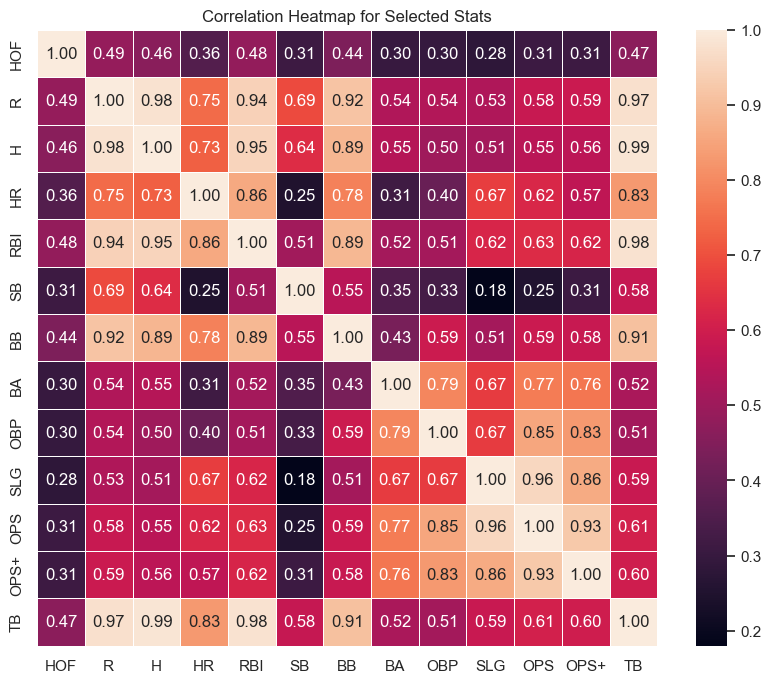

In [299]:
# Extract the selected statistics and create a correlation matrix
correlation_matrix = batting_stats[['HOF'] + relevant_stats].corr()

# Create a heatmap using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap for Selected Stats')
plt.show()

Taking a look at the heat map we can see that nothing has an overwhelming correlation to the target feature HOF but there are a few that standout. We'll consider R, H, RBI, BB,TB. (Runs, Hits, Runs Batted In, ). Lets get a good feel for the distribution of these points plotted against the top 2 correlated features.  

In [300]:
# Create scatter plot with hover information and color-coded points
fig = px.scatter(batting_stats, x='RBI', y='R', color='HOF', hover_data=['Player', 'HOF'],
                 color_discrete_map={True: 'orange', False: 'blue'},
                 labels={'RBI': 'Runs Batted In', 'R': 'Runs'})

# Update layout for better aesthetics
fig.update_layout(title='RBI vs. R with HOF Color Coding',
                  xaxis_title='Runs Batted In (RBI)',
                  yaxis_title='Runs (R)')

# Show the plot
fig.show()

Using this graph of the distribution across Runs and RBI's we get a pretty good sense check that these are some good indicators of Hall of Fame statistics. It's not perfect but we do get a visual of a large cluster of non Hall of Fame players getting more and more sprinkled with HOF indicators leading into the upper right corner of the graph. The upper corner of the graph is the area of HOFers and players that either still have the chance to make it, or have an external social reason they did not.  For the 3 blue players in this graph that are top right, we have Albert Puljos (just retired and has not been eligible for the ballot yet), Alex Rodriguez who is a controversial figure due to PED (Performance Enhancing Drugs) allegations, and Barry Bonds confirmed PED usage. Also fun side note, I was at the game where Albert Puljos hit his 699th and 700th HR, a number that only 4 players in history have ever reached. 

## Analysis

Now with that fun stuff out of the way, I want to note that there are several HOF yellow points at the bottom left of the graph, these are players with rather incomplete data sets due to historical context, however we're going to look at the performance of the model with these points included and decide after if its worth removing. We'll write up our code for the model and analyze it with a confusion matrix and ROC-AUC Score.

In [301]:


# Features (X) and Target (y)
X = batting_stats[['R', 'H', 'RBI', 'BB', 'TB']]
y = batting_stats['HOF']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a logistic regression model
model = LogisticRegression()

# Train the model on the training set
model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# Display evaluation metrics
print(f'Accuracy: {accuracy:.2f}')
print('\nConfusion Matrix:\n', conf_matrix)
print('\nClassification Report:\n', classification_rep)

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

print(f'\nROC AUC: {roc_auc}')


Accuracy: 0.97

Confusion Matrix:
 [[1213    8]
 [  33   20]]

Classification Report:
               precision    recall  f1-score   support

       False       0.97      0.99      0.98      1221
        True       0.71      0.38      0.49        53

    accuracy                           0.97      1274
   macro avg       0.84      0.69      0.74      1274
weighted avg       0.96      0.97      0.96      1274


ROC AUC: 0.9606725078423192


Looking at the confusion matrix we have a fairly high accuracy and weighted average for both precision and recall, but we have a pretty underperformed classifier for identifying current Hall of Fame players. We're able to accurately define a non-HOFer which is understandably easy, however its concerning that we have more False Negatives than true positives for the HOF class. Given that our HOF indicator is a small minority of the over all data.

In [302]:
print(batting_stats['HOF'].value_counts())
print(190/6177)

HOF
False    6177
True      190
Name: count, dtype: int64
0.030759268253197344


The HOF data represents 3 percent of the data, which is already cut down compared to the whole history of the MLB. While Logistic Regression is normally great and offers a lot of insight into the mechanics of the calculation, I don't think its the best choice for our model methodology. One thing to try before testing out a different modeling method, is changing the features we're considering in a more methodical way. At the moment I chose the highest correlation features however in our case, the features were also highly correlated with eachother leading to an issue of collinearity. We're going to stick with the highest correlated feature and stay away from any others that are heavily correlated with those. This time we'll try out R, HR, SB, OPS+, and BA (Runs, Home Runs, Stolen Bases, OPS+, and Batting Average).

In [303]:


# Features (X) and Target (y)
X = batting_stats[['R', 'HR', 'SB', 'OPS+', 'BA']]
y = batting_stats['HOF']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a logistic regression model
model = LogisticRegression()

# Train the model on the training set
model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# Display evaluation metrics
print(f'Accuracy: {accuracy:.2f}')
print('\nConfusion Matrix:\n', conf_matrix)
print('\nClassification Report:\n', classification_rep)

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

print(f'\nROC AUC: {roc_auc}')


Accuracy: 0.97

Confusion Matrix:
 [[1217    4]
 [  32   21]]

Classification Report:
               precision    recall  f1-score   support

       False       0.97      1.00      0.99      1221
        True       0.84      0.40      0.54        53

    accuracy                           0.97      1274
   macro avg       0.91      0.70      0.76      1274
weighted avg       0.97      0.97      0.97      1274


ROC AUC: 0.9776551852023551


From our new classifier performance it looks like we're still having some trouble, we improved by 1 less false negative and 1 more correct prediction, however instead of doing this manually, lets use some feature selection techniques that are statistically backed. Since Random Forest tends to do pretty well with unbalanced samples we're going to give that a try. 

In [304]:
X = batting_stats[relevant_stats]  
y = batting_stats['HOF']           

rf_classifier = RandomForestClassifier()
rf_classifier.fit(X, y)

feature_importances = rf_classifier.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# Sort features by importance (descending order)
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print(feature_importance_df.head())



   Feature  Importance
0        R    0.181764
1        H    0.152705
11      TB    0.113450
6       BA    0.097636
3      RBI    0.091909


Next we'll take a look at our model with these 5 features, and then try the top 3 features to lessen the complexity. I have one more method I want to try but we'll give this a shot first before moving to my last idea. 

In [305]:


# Features (X) and Target (y)
X = batting_stats[['R', 'H', 'TB', 'BA', 'RBI']]
y = batting_stats['HOF']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a logistic regression model
model = LogisticRegression()

# Train the model on the training set
model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# Display evaluation metrics
print(f'Accuracy: {accuracy:.2f}')
print('\nConfusion Matrix:\n', conf_matrix)
print('\nClassification Report:\n', classification_rep)

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)
print(f'\nROC AUC: {roc_auc}')


Accuracy: 0.97

Confusion Matrix:
 [[1213    8]
 [  33   20]]

Classification Report:
               precision    recall  f1-score   support

       False       0.97      0.99      0.98      1221
        True       0.71      0.38      0.49        53

    accuracy                           0.97      1274
   macro avg       0.84      0.69      0.74      1274
weighted avg       0.96      0.97      0.96      1274


ROC AUC: 0.962434132245453


The model has decreased in ROC score after this iteration, so lets try the top 3 features and move on if we're not happy with the results. 

In [306]:


# Features (X) and Target (y)
X = batting_stats[['R', 'H', 'TB']]
y = batting_stats['HOF']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a logistic regression model
model = LogisticRegression()

# Train the model on the training set
model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# Display evaluation metrics
print(f'Accuracy: {accuracy:.2f}')
print('\nConfusion Matrix:\n', conf_matrix)
print('\nClassification Report:\n', classification_rep)

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)
print(f'\nROC AUC: {roc_auc}')


Accuracy: 0.97

Confusion Matrix:
 [[1216    5]
 [  33   20]]

Classification Report:
               precision    recall  f1-score   support

       False       0.97      1.00      0.98      1221
        True       0.80      0.38      0.51        53

    accuracy                           0.97      1274
   macro avg       0.89      0.69      0.75      1274
weighted avg       0.97      0.97      0.96      1274


ROC AUC: 0.9497473459737611


Similar deal with this model, so we'll move on to a method that's more robust with unbalanced data. We're gonna try a random forest binary classifier since it does a good job with feature selection as well as minority target features. I'll print out the selection features and set the threshold for important features at 0.075.

In [307]:


X = batting_stats[relevant_stats]  
y = batting_stats['HOF']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the classifier to the training data
rf_classifier.fit(X_train, y_train)

# Feature Importances
feature_importances = pd.Series(rf_classifier.feature_importances_, index=X.columns)
selected_features = feature_importances[feature_importances > 0.075].index  # Adjust the threshold as needed

# Select only the important features for training and testing
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Retrain the classifier on the selected features
rf_classifier.fit(X_train_selected, y_train)

# Predictions on the testing set
y_pred = rf_classifier.predict(X_test_selected)
print(selected_features)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Classification Report
class_report = classification_report(y_test, y_pred)
print("\nClassification Report:")
print(class_report)

# ROC-AUC Score
roc_auc = roc_auc_score(y_test, rf_classifier.predict_proba(X_test_selected)[:, 1])
print(f"\nROC-AUC Score: {roc_auc:.4f}")

Index(['R', 'H', 'RBI', 'BA', 'TB'], dtype='object')
Confusion Matrix:
[[1211   10]
 [  16   37]]

Classification Report:
              precision    recall  f1-score   support

       False       0.99      0.99      0.99      1221
        True       0.79      0.70      0.74        53

    accuracy                           0.98      1274
   macro avg       0.89      0.84      0.86      1274
weighted avg       0.98      0.98      0.98      1274


ROC-AUC Score: 0.9636


## Results

Now this is what we were looking for since this method now recognizes a much larger amount of Hall of Fame players and also falsely predicts a few players as well. For our purposes this is a good thing as it shows that there are players who may deserve to be that are not, and players that it is predicting might be in the future due to eligibility reasons. I'm happy with this version of the model as it has a high ability to recognize HOF players while also having its own opinions about players that currently are not there. First, we'll take a look at the models performance amongst HOF players.

In [308]:
batting_stats['HOF_pred'] = rf_classifier.predict(batting_stats[selected_features])
batting_stats['HOF_prob'] = rf_classifier.predict_proba(batting_stats[selected_features])[:, 1]

plot_data = batting_stats[batting_stats['HOF'] == True][['FirYr', 'HOF_prob', 'Player']]

threshold = 0.5
plot_data['Threshold'] = threshold

# Create a hover text with player names and probabilities
hover_text = plot_data.apply(lambda row: f"{row['Player']}<br>Probability: {row['HOF_prob']:.4f}", axis=1)
plot_data['HoverText'] = hover_text

# Create the interactive plot
fig = px.scatter(plot_data, x='FirYr', y='HOF_prob', hover_data=['HoverText'],
                 labels={'HOF_prob': 'Probability', 'FirYr': 'First Year'},
                 title='HOF Probability over Time')

# Add a threshold line
fig.add_shape(
    dict(
        type='line',
        x0=plot_data['FirYr'].min(),
        x1=plot_data['FirYr'].max(),
        y0=threshold,
        y1=threshold,
        line=dict(color='red', dash='dash'),
    )
)

# Show the interactive plot
fig.show()


This is where our model shined, while this does worry me a little bit in terms of overfitting to our data, its pretty accurate nonetheless. We want a majority of the numbers above the line so that we can see how well the model was trained. Lets take a look at some of the names it missed. 

In [309]:
display(batting_stats[(batting_stats['HOF'] == True) & (batting_stats['HOF_pred'] == False)][['Player','HOF_prob','G','AB','To'] + relevant_stats].sort_values('HOF_prob', ascending=False))

,Player,HOF_prob,G,AB,To,R,H,HR,RBI,SB,BB,BA,OBP,SLG,OPS,OPS+,TB
2582,Billy Williams,0.50,2488,9350,1976,1410,2711,426,1475.0,90.0,1045,0.290,0.361,0.492,0.853,133.0,4599
319,Chick Hafey,0.25,1283,4625,1937,777,1466,164,833.0,70.0,372,0.317,0.372,0.526,0.898,133.0,2433
742,Billy Herman,0.23,1922,7707,1947,1163,2345,47,839.0,67.0,737,0.304,0.367,0.407,0.774,112.0,3136
1644,Yogi Berra,0.19,2120,7555,1965,1175,2150,358,1430.0,30.0,704,0.285,0.348,0.482,0.830,125.0,3643
3092,Johnny Bench,0.14,2158,7658,1983,1091,2048,389,1376.0,68.0,891,0.267,0.342,0.476,0.817,126.0,3644
8791,Gabby Hartnett,0.07,1990,6432,1941,867,1912,236,1179.0,28.0,703,0.297,0.370,0.489,0.858,126.0,3144
1669,Ralph Kiner,0.05,1472,5205,1955,971,1451,369,1015.0,22.0,1011,0.279,0.398,0.548,0.946,149.0,2852
4439,Jimmy Collins,0.04,1725,6795,1908,1055,1999,65,983.0,194.0,426,0.294,0.343,0.409,0.752,113.0,2778
8734,John Henry Lloyd,0.04,433,1629,1929,297,569,16,308.0,59.0,133,0.349,0.400,0.465,0.865,131.0,758
2642,Ron Santo,0.03,2243,8143,1974,1138,2254,342,1331.0,35.0,1108,0.277,0.362,0.464,0.826,125.0,3779


I don't know much about these players, especially since most of them last played before the 1970's but one thing I do notice is that our model struggled to find a balance between some of the quantity stats and quality stats. I'm seeing players with high batting averages or high hit counts but lacking in a few of the other statistics. This passes the initial feel check and might be a victim of the changing landscape of baseball stats, however these stats are still above average for a baseball player. Next lets take a look at the Non-HOFers and how we did there. 

In [310]:
batting_stats['HOF_pred'] = rf_classifier.predict(batting_stats[selected_features])
batting_stats['HOF_prob'] = rf_classifier.predict_proba(batting_stats[selected_features])[:, 1]

plot_data = batting_stats[batting_stats['HOF'] == False][['FirYr', 'HOF_prob', 'Player']]

threshold = 0.5
plot_data['Threshold'] = threshold

# Create a hover text with player names and probabilities
hover_text = plot_data.apply(lambda row: f"{row['Player']}<br>Probability: {row['HOF_prob']:.4f}", axis=1)
plot_data['HoverText'] = hover_text

# Create the interactive plot
fig = px.scatter(plot_data, x='FirYr', y='HOF_prob', hover_data=['HoverText'],
                 labels={'HOF_prob': 'Probability', 'FirYr': 'First Year'},
                 title='HOF Probability over Time')

# Add a threshold line
fig.add_shape(
    dict(
        type='line',
        x0=plot_data['FirYr'].min(),
        x1=plot_data['FirYr'].max(),
        y0=threshold,
        y1=threshold,
        line=dict(color='red', dash='dash'),
    )
)

# Show the interactive plot
fig.show()


First we'll take a look at the probability chart with players that are currently not in the Hall of Fame and see where they stack up. Everything over the line has a predicted HOF value while everything under didn't quite make it. You can hover over the dots and explore the chart to see where every lies but we'll highlight the people over the line as well as a few players just under. 

In [311]:
display(batting_stats[(batting_stats['HOF'] == False) & (batting_stats['HOF_pred'] == True)][['Player','HOF_prob','G','AB','To'] + relevant_stats].sort_values('HOF_prob', ascending=False))

,Player,HOF_prob,G,AB,To,R,H,HR,RBI,SB,BB,BA,OBP,SLG,OPS,OPS+,TB
4622,Rafael Palmeiro,0.95,2831,10472,2005,1663,3020,569,1835.0,97.0,1353,0.288,0.371,0.515,0.885,132.0,5388
5523,Carlos BeltrÃ¡n,0.74,2586,9768,2017,1582,2725,435,1587.0,312.0,1084,0.279,0.350,0.486,0.837,119.0,4751
80,Dave Orr,0.65,791,3289,1890,536,1125,37,627.0,66.0,98,0.342,0.366,0.502,0.867,162.0,1650
4986,Kenny Lofton,0.62,2103,8120,2007,1528,2428,130,781.0,622.0,945,0.299,0.372,0.423,0.794,107.0,3433
768,Dixie Walker,0.58,1905,6740,1949,1038,2064,105,1023.0,59.0,817,0.306,0.383,0.437,0.820,121.0,2947
5022,Bernie Williams,0.58,2076,7869,2006,1366,2336,287,1257.0,147.0,1069,0.297,0.381,0.477,0.858,125.0,3756
5061,Jeff Kent,0.57,2298,8498,2008,1320,2461,377,1518.0,94.0,801,0.290,0.356,0.500,0.855,123.0,4246
5384,Nomar Garciaparra,0.55,1434,5586,2009,927,1747,229,936.0,95.0,403,0.313,0.361,0.521,0.882,124.0,2908
2234,Lave Cross,0.54,2277,9084,1907,1338,2651,47,1378.0,303.0,466,0.292,0.329,0.383,0.711,100.0,3475
8660,Bob Meusel,0.53,1407,5475,1930,826,1693,156,1071.0,143.0,375,0.309,0.356,0.497,0.852,118.0,2719


## Discussion

From this list anyone with a 'To' year before 2014 is no longer eligible to be elected to the Hall of fame, so those predictions are more indicative of players who had a really good shot to make it. The voting process for the MLB Hall of Fame is conducted by long term members for the Baseball Writers' Association of America and is quite subjective. There's not benchmarks or mininmum requirements, people vote and if 75% of voters then you're in. This is where we can see what caused players to miss out since most of these players are definitely in the conversation.

### Top Predictions
**Rafael Palmiero** - Missed out on induction earning a max amount of 11% of the votes, he tested positive for PED's in 2005 and that essentially bars you from ever being on this list. 
**Carlos Beltran** - Had his first year of eligibility in 2023 and recieved 46.5% of votes needed. His chances are looking up for next years vote.
**Dave Orr** - (This was one I didn't know) Dave boasts some incredible stats, but suffered a paralyzing stroke in the prime of his career. 
**Kenny Lofton** -  Had incredible stats but didn't reach the 3000 hit club and had some other players on the list during his eligibility that have since been elected
**Dixie Walker** - Was a major player in the opposition of Jackie Robinson joining the Dodgers, breaking the color barrier
**Bernie Williams** - By other advanced metrics he should be in the Hall of Fame, however he was a quiet player and wasn't the best defensively
**Jeff Kent** - Just missed out on his last year on the ballot (46.5%), has been gaining support to be inducted by committee
**Nomar Garciaparra** - He wasn't HOF caliber for long enough in his career, great prime years but failed to do it consistantly
**Lave Cross** - This is one I cant find much on, might be a classifier anomaly
**Bob Meusel** - Was overshadowed by other players on his team during his career, great stats for his time. 




### Notable Non-Predictions but close

**Bobby Abreu** 
**Manny Ramirez**
**Vada Pinson**

I wont go in depth for these names because while the argument could be made for each one of them, they aren't an instant lock for the Hall of Fame in my eyes, they all had their impact on the game and fans loved them but they may have not done enough on the stat sheet. 

### Ok Maybe This Classifier doesn't know anything
**Pete Rose**
**Mark McGuire**
**Ichiro Suzuki**
**Albert Puljos**
**Barry Bonds**

Now these are the names that make want to redo this entire project over again and figure out where we went wrong, but this is where the learning comes in. These 5 names are instant locks for the hall of fame based off stats alone. To be fair, it's like the predictor somehow knew about the outside scandals that players had since 2 of these names will never make it based off PED usage (Barry Bonds and Mark Mcguire). Despite that, these 2 players should absolutely be in the Hall of Fame based off their numbers. Barry Bonds has the most Home Runs in the entire MLB history, I mean he was soo good that teams would intentionally walk him with bases loaded, intentionally giving up a run because it was a better bet than letting him try to hit the ball. This classifier is wrong, I made it but it's wrong. Pete Rose is another player that it just has wrong, he has the most hits all time in the MLB but has been banned from the Hall of Fame due to gambling on games he played in. Now these last two names just hurt, I mentioned Albert Puljos earlier so seeing him not on the prediction list is tough but from this data I can tell that HR's had little to no influence (especially since it wasn't in the classifier features). Ichiro Suziki is another name that is just wrong, he was one of the best players during his career and beloved by his fans here and back home in Japan. I was pretty happy with the classifier when looking at the raw numbers but as we can see, there are some pretty notable players left off here. I'll leave a list of the misses below for exploration. 

In [312]:
display(batting_stats[(batting_stats['HOF'] == False) & (batting_stats['HOF_pred'] == False)][['Player', 'HOF_prob', 'G', 'AB', 'To'] + relevant_stats].nlargest(20, 'HOF_prob').sort_values('HOF_prob', ascending=False))


,Player,HOF_prob,G,AB,To,R,H,HR,RBI,SB,BB,BA,OBP,SLG,OPS,OPS+,TB
5495,Magglio OrdÃ³Ã±ez,0.47,1848,6978,2011,1076,2156,294,1236.0,94.0,651,0.309,0.369,0.502,0.871,125.0,3506
8245,Bobby Veach,0.45,1821,6656,1925,957,2063,64,1174.0,195.0,571,0.310,0.370,0.442,0.812,127.0,2942
2516,Vada Pinson,0.44,2469,9645,1975,1365,2757,256,1169.0,305.0,574,0.286,0.327,0.442,0.769,111.0,4264
4661,Ellis Burks,0.44,2000,7232,2004,1253,2107,352,1206.0,181.0,793,0.291,0.363,0.510,0.874,126.0,3691
2863,Pete Rose,0.43,3562,14053,1986,2165,4256,160,1314.0,198.0,1566,0.303,0.375,0.409,0.784,118.0,5752
5357,Bobby Abreu,0.41,2425,8480,2014,1453,2470,288,1363.0,400.0,1476,0.291,0.395,0.475,0.870,128.0,4026
8563,Lefty O'Doul,0.38,970,3264,1934,624,1140,113,542.0,36.0,333,0.349,0.413,0.532,0.945,143.0,1736
2258,George Van Haltren,0.37,1990,8043,1903,1642,2544,69,1015.0,583.0,871,0.316,0.386,0.418,0.803,122.0,3359
5172,Manny RamÃ­rez,0.37,2302,8244,2011,1544,2574,555,1831.0,38.0,1329,0.312,0.411,0.585,0.996,154.0,4826
9053,Harry Stovey,0.36,1489,6153,1893,1495,1775,122,912.0,509.0,664,0.288,0.361,0.462,0.822,144.0,2841


I mean Barry Bonds doesn't even make this list of the top 20 misses. Thats nuts. 

Lastly, for fun and my own interest, lets take a look at some of the current players with the top probabilities. 

In [313]:
display(batting_stats[(batting_stats['HOF_pred'] == False) & (batting_stats['To'] == 2023)][['Player', 'HOF_prob', 'G', 'AB', 'To'] + relevant_stats].nlargest(20, 'HOF_prob').sort_values('HOF_prob', ascending=False))


,Player,HOF_prob,G,AB,To,R,H,HR,RBI,SB,BB,BA,OBP,SLG,OPS,OPS+,TB
5962,Miguel Cabrera,0.32,2797,10356,2023,1551,3174,511,1881.0,40.0,1258,0.306,0.382,0.518,0.901,140.0,5368
6896,JosÃ© Altuve,0.22,1668,6665,2023,1062,2047,209,747.0,293.0,553,0.307,0.364,0.471,0.834,129.0,3136
6826,Freddie Freeman,0.10,1885,7016,2023,1217,2114,321,1143.0,89.0,932,0.301,0.388,0.514,0.902,142.0,3608
6143,Nelson Cruz,0.07,2055,7501,2023,1090,2053,464,1325.0,84.0,738,0.274,0.343,0.513,0.856,130.0,3847
6989,Mike Trout,0.07,1489,5402,2023,1106,1624,368,940.0,206.0,964,0.301,0.412,0.582,0.994,173.0,3142
7185,Mookie Betts,0.07,1265,5044,2023,996,1485,252,756.0,172.0,614,0.294,0.373,0.527,0.900,138.0,2656
6938,Eric Hosmer,0.03,1689,6349,2023,812,1753,198,893.0,76.0,562,0.276,0.335,0.427,0.762,107.0,2709
7346,Kyle Schwarber,0.03,979,3367,2023,579,763,246,548.0,22.0,550,0.227,0.340,0.492,0.831,121.0,1655
7626,Luis ArrÃ¡ez,0.03,536,1987,2023,287,647,24,201.0,11.0,172,0.326,0.379,0.427,0.806,123.0,848
7045,Manny Machado,0.02,1583,6216,2023,914,1737,313,944.0,88.0,563,0.279,0.339,0.490,0.829,125.0,3045


If you know baseball, a lot of the names on here definitely make sense and pass the general smell check but the ordering shows the flaws and priorities in the model. 

For some more context, here a link to the page of the top WAR leaders (Wins Above Replacement -  A single number that presents the number of wins the player added to the team above what a replacement player (think AAA or AAAA) would add.) Many of them overlap with this list, so we're doing something right. 

https://www.baseball-reference.com/leaders/WAR_bat_active.shtml



## Conclusion

We set out to take a look at hall of fame stats and try to optimize a classifier that would give us a look into predicting Hall of Famers based off simple stats. Now we definitely did that but we must acknowledge that baseball stats are hard to work with and sway the balance between raw quantity and quality. The classifier was correct in a lot of ways but failed to see a lot of the greatness in front of it. We did pretty well to recognize Hall of Famers themselves but seemed to have difficulty picking out players that most MLB fans would say are some of the best players ever. Some more work needs to be done and a key upgrade to this method is to add in defensive stats, accolades and advanced metrics, however we accomplished what we wanted with a rudimentary set of stats. I don't think I can ever forgive myself for creating something that doesn't think Barry Bonds and Albert Puljos are not Hall of Famers but we built something that did its job in a rather unique way. Maybe we should leave the Hall of Fame induction process to the professionals. Go Dodgers.   